In [27]:
%matplotlib inline
import gym
import math
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from collections import deque
from IPython.display import display
from JSAnimation.IPython_display import display_animation
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from matplotlib import animation
from scipy import stats
from training_methods import *
%load_ext autoreload
%autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
def display_frames_as_gif(frames):
    """
    Displays a list of frames as a gif, with controls
    """
    plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi = 72)
    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=50)
    display(display_animation(anim, default_mode='loop'))

In [35]:
def evaluate(env, agent, params, render, frames):
    state = env.reset()
    render_frames = []
    for e in range(frames):
        if render:
            render_frames.append(env.render(mode = 'rgb_array'))
        state = np.reshape(state, [1, params.state_size])
        action = agent.act_greedy(state, e)
        state, reward, done, _ = env.step(action)
        if done or e == frames - 1:
            print("score: {}"
                  .format(e))
            break

    if render:
        env.render(close=True)
        display_frames_as_gif(render_frames)

In [3]:
class LearningParameters:
    def __init__(self, state_size, action_size, episodes_count):
        self.state_size = state_size
        self.action_size = action_size
        self.episodes_count = episodes_count
        self.max_frame_in_episode = 500
        self.max_memory_size = 10000
        self.episodes_between_think = 5
        
        self.gamma = 0.95                # discount rate
        self.epsilon = 1.0               # exploration rate
        self.epsilon_start = self.epsilon
        self.epsilon_min = 0.0001        # min exploration rate
        self.learning_rate = 0.1         # learning rate for algorithm
        self.learning_rate_model = 0.01  # learning rate for model

    def decay_exploration_rate(self, episode):
        # Linear exploration rate decay (lerp)
#         self.epsilon = self.epsilon_start - \
#                       (self.epsilon_start - self.epsilon_min) * (float(frame) / self.frames_count)
            
        # Exponential rate decay
        # y(0) = start
        # y(1) = start * x
        # y(2) = start * x^2
        # y(steps) = start * x^steps = min => x = (min/start) ^ (1/steps)
        # y(t) = start * x^t
        self.epsilon = self.epsilon_start * \
                       math.pow( math.pow(self.epsilon_min / self.epsilon_start, 1.0 / self.episodes_count), episode )

## Action is added to input as OHE

In [62]:
class ActionAsInputAgent:
    def __init__(self, params):
        self.params = params
        self.memory = deque(maxlen=self.params.max_memory_size)
        self.model = self._build_model()
        
    def _build_model(self):
        input_len = self.params.state_size + self.params.action_size

        x = tf.placeholder("float", [None, input_len], name="Placeholder_x")
        y = tf.placeholder("float", [None, 1], name="Placeholder_y")
        
        w0 = tf.Variable(tf.random_normal([input_len, 20]))
        b0 = tf.Variable(tf.random_normal([20]))
        w1 = tf.Variable(tf.random_normal([20, 1]))
        b1 = tf.Variable(tf.random_normal([1]))
        
        h0 = tf.add(tf.matmul(x, w0), b0)
        h0 = tf.nn.relu(h0)
        
        pred = tf.add(tf.matmul(h0, w1), b1)
        
        cost = tf.nn.l2_loss(pred - y)
        train_op = tf.train.RMSPropOptimizer(learning_rate=self.params.learning_rate, decay=0.99).minimize(cost)
        
        init = tf.global_variables_initializer()
        
        return {
            'x': x,
            'y': y,
            'pred': pred,
            'cost': cost,
            'train_op': train_op,
            'init': init
        }

    def remember(self, state, action, reward, next_state, frame):
        self.memory.append((state, action, reward, next_state, frame))

    def act(self, state, frame):
        if np.random.rand() <= self.params.epsilon:
            return np.random.randint(0, self.params.action_size)
        return self.act_greedy(state, frame)
    
    def act_greedy(self, state, frame):
        x = self.model['x']
        pred = self.model['pred']

        X = np.resize(state[0], (1, self.params.state_size + self.params.action_size))
        X[0, self.params.state_size:] = 0
        rewards = np.zeros((self.params.action_size))
        for i in range(self.params.action_size):
            X[0, self.params.state_size + i] = 1
            rewards[i] = session.run(pred, {x: X})[0]
            X[0, self.params.state_size + i] = 0
        return np.argmax(rewards)
    
    def think(self, batch_size):
        x = self.model['x']
        y = self.model['y']
        pred = self.model['pred']
        train_op = self.model['train_op']
        cost = self.model['cost']
        
        cnt = len(self.memory)
        X = np.zeros((cnt, self.params.state_size + self.params.action_size))
        Y = np.zeros((cnt, 1))
        for i in range(cnt):
            state, action, reward, next_state, frame = self.memory[i]
            state = np.resize(state[0], (self.params.state_size + self.params.action_size))
            state[self.params.state_size:] = 0
            state[self.params.state_size + action] = 1
            X[i], Y[i] = state, reward

        for e in range(1):
            P = np.random.permutation(cnt)
            for i in range(0, cnt, batch_size):
                batch_indexes = P[i: i + batch_size]
                batch_x = X[batch_indexes]
                batch_y = Y[batch_indexes]
                _ = session.run(train_op, {x: batch_x, y: batch_y})

## Policy Gradient

Run with `params.episodes_between_think = 1`

Karpathy: https://gist.github.com/karpathy/a4166c7fe253700972fcbc77e4ea32c5

TF interpretation: https://gist.github.com/greydanus/5036f784eec2036252e1990da21eda18

TODO:
* PG magic with normalizing discounted reward
* PG magic with multiplying logprob to normalized discounted reward

In [20]:
class PolicyGradientAgent:
    def __init__(self, params):
        self.params = params
        self.memory = deque(maxlen=self.params.max_memory_size)
        self.model = self._build_model()

    def _build_model(self):
        x = tf.placeholder("float", [None, self.params.state_size], name='Placeholder_x')
        y = tf.placeholder("float", [None, self.params.action_size], name='Placeholder_y')
        
        w0 = tf.Variable(tf.random_normal([self.params.state_size, 20]))
        b0 = tf.Variable(tf.random_normal([20]))
        w1 = tf.Variable(tf.random_normal([20, self.params.action_size]))
        b1 = tf.Variable(tf.random_normal([self.params.action_size]))
        
        h0 = tf.add(tf.matmul(x, w0), b0)
        h0 = tf.nn.relu(h0)
        
        logits = tf.add(tf.matmul(h0, w1), b1)
        pred = tf.nn.softmax(logits)

        cost = tf.nn.l2_loss(pred - y)
        
        optimizer = tf.train.RMSPropOptimizer(self.params.learning_rate_model, decay=0.99)
        gradients = optimizer.compute_gradients(cost, var_list=tf.trainable_variables())
        train_op = optimizer.apply_gradients(gradients)
        
        init = tf.global_variables_initializer()
        
        return {
            'x': x,
            'y': y,
            'pred': pred,
            'cost': cost,
            'init': init,
            'train_op': train_op
        }

    def remember(self, state, action, reward, next_state, frame):
        self.memory.append((state, action, reward, next_state))

    def act(self, state, frame):
        if np.random.rand() <= self.params.epsilon:
            return np.random.randint(0, self.params.action_size)
        return self.act_greedy(state, frame)
    
    def act_greedy(self, state, frame):
        x = self.model['x']
        pred = self.model['pred']
        act_values = session.run(pred, feed_dict={x: state})[0]
        return np.argmax(act_values)

    def think(self, batch_size):
        x = self.model['x']
        y = self.model['y']
        pred = self.model['pred']
        train_op = self.model['train_op']
        
        cnt = len(self.memory)
        X = np.zeros((cnt, self.params.state_size))
        Y = np.zeros((cnt, self.params.action_size))
        for i in range(cnt):
            state, action, reward, next_state = self.memory[i]
            target = session.run(pred, feed_dict={x: state})[0]
            target[action] = reward
            X[i], Y[i] = state, target

        _ = session.run(train_op, {x: X, y: Y})

## DQN Agent

In [21]:
class DqnAgent:
    def __init__(self, params):
        self.params = params
        self.memory = deque(maxlen=self.params.max_memory_size)
        self.model = self._build_model()

    def _build_model(self):
        x = tf.placeholder("float", [None, self.params.state_size], name="Placeholder_x")
        y = tf.placeholder("float", [None, self.params.action_size], name="Placeholder_y")
        
        w0 = tf.Variable(tf.random_normal([self.params.state_size, 24]))
        b0 = tf.Variable(tf.random_normal([24]))
        w1 = tf.Variable(tf.random_normal([24, self.params.action_size]))
        b1 = tf.Variable(tf.random_normal([self.params.action_size]))
        
        h0 = tf.add(tf.matmul(x, w0), b0)
        h0 = tf.nn.relu(h0)
        
        pred = tf.add(tf.matmul(h0, w1), b1)
        
        cost = tf.nn.l2_loss(pred - y)
#         cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y))
        train_op = tf.train.RMSPropOptimizer(learning_rate=self.params.learning_rate, decay=0.99).minimize(cost)
#         train_op = tf.train.AdamOptimizer(learning_rate=self.params.learning_rate_model).minimize(cost)
        
        init = tf.global_variables_initializer()
        
        return {
            'x': x,
            'y': y,
            'pred': pred,
            'cost': cost,
            'init': init,
            'train_op': train_op
        }

    def remember(self, state, action, reward, next_state, frame):
        self.memory.append((state, action, reward, next_state))

    def act(self, state, frame):
        if np.random.rand() <= self.params.epsilon:
            return np.random.randint(0, self.params.action_size)
        return self.act_greedy(state, frame)
    
    def act_greedy(self, state, frame):
        x = self.model['x']
        pred = self.model['pred']
        act_values = session.run(pred, {x: state})
        return np.argmax(act_values[0])

    def think(self, batch_size):
        x = self.model['x']
        y = self.model['y']
        pred = self.model['pred']
        train_op = self.model['train_op']
        cost = self.model['cost']
        
        cnt = len(self.memory)
        X = np.zeros((cnt, self.params.state_size))
        Y = np.zeros((cnt, self.params.action_size))
        for i in range(cnt):
            state, action, reward, next_state = self.memory[i]
            target = session.run(pred, {x: state})[0]
            target[action] = reward + self.params.gamma * \
                             np.amax(session.run(pred, {x: next_state})[0])
            X[i], Y[i] = state, target

        for e in range(1):
            P = np.random.permutation(cnt)
            for i in range(0, cnt, batch_size):
                batch_indexes = P[i: i + batch_size]
                batch_x = X[batch_indexes]
                batch_y = Y[batch_indexes]
                _ = session.run(train_op, {x: batch_x, y: batch_y})


In [5]:
# print(env.spec.max_episode_steps)
# env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env.render(close=True)

[2017-07-03 19:02:38,584] Making new env: CartPole-v1


episode: 5/100, reward 22.0, exploration rate: 0.76
episode: 10/100, reward 18.2, exploration rate: 0.48
episode: 15/100, reward 14.7, exploration rate: 0.3
episode: 20/100, reward 34.6, exploration rate: 0.19
episode: 25/100, reward 42.9, exploration rate: 0.12
episode: 30/100, reward 42.0, exploration rate: 0.076
episode: 35/100, reward 67.1, exploration rate: 0.048
episode: 40/100, reward 80.6, exploration rate: 0.03
episode: 45/100, reward 94.6, exploration rate: 0.019
episode: 50/100, reward 105.1, exploration rate: 0.012
episode: 55/100, reward 144.5, exploration rate: 0.0076
episode: 60/100, reward 258.1, exploration rate: 0.0048
episode: 65/100, reward 364.0, exploration rate: 0.003
episode: 70/100, reward 449.7, exploration rate: 0.0019
episode: 75/100, reward 430.5, exploration rate: 0.0012
episode: 80/100, reward 430.5, exploration rate: 0.00076
episode: 85/100, reward 356.3, exploration rate: 0.00048
episode: 90/100, reward 193.7, exploration rate: 0.0003
episode: 95/100, r

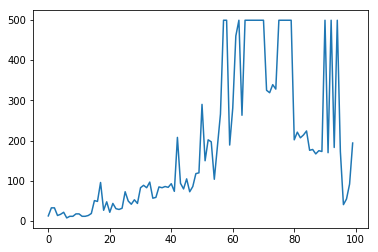

In [63]:
params = LearningParameters(env.observation_space.shape[0], env.action_space.n, 100)

# params.episodes_between_think = 1
# agent = PolicyGradientAgent(params)

# agent = DqnAgent(params)

agent = ActionAsInputAgent(params)

if 'session' in locals():
    session.close()
session = tf.Session()
session.run(agent.model['init'])

agent, rewards = train_reward_is_time(env, agent, params)
# agent, rewards = train(env, agent, params)
# agent, rewards = train_reward_is_time(env, ActionAsInputAgent(params), params)
plt.plot(rewards)

In [55]:
evaluate(env, agent, params, False, 500)

score: 499
